# Updating and deciding: Gamma distributions

We repeat the simulations from notebook `Section4A.ipynb` with Gamma distributions instead of Weibull distributions used for modeling probability of death. For explanation of the simulations, the reader is referred to the aforementioned notebook.

### Setup

In [1]:
# parallel computing
addprocs(3);

In [2]:
# needed packages
@everywhere using Distributions
using Gadfly, DataFrames, Colors

In [3]:
# default graphics
Gadfly.push_theme(:default)
set_default_plot_size(9inch, 9inch/golden)

function gen_brew_colors(n) # to create your own colors, here based on one of the brewer series
    cs = distinguishable_colors(n, 
        [colorant"#66c2a5", colorant"#fc8d62", colorant"#8da0cb", colorant"#e78ac3",
            colorant"#a6d854", colorant"#ffd92f", colorant"#e5c494", colorant"#b3b3b3"],
        lchoices=Float64[58, 45, 72.5, 90],
        transform=c -> deuteranopic(c, 0.1),
        cchoices=Float64[20,40],
        hchoices=[75,51,35,120,180,210,270,310]
    )
    convert(Vector{Color}, cs)
end

gen_brew_colors (generic function with 1 method)

In [4]:
# set parameters, define priors, etc.
@everywhere const numb_hyp = 11
@everywhere const numb_toss = 500
@everywhere const numb_sim = 1000

@everywhere const prior = fill(Float32(1/numb_hyp), numb_hyp)
@everywhere const likelihood_heads = linspace(0f0, 1, numb_hyp)
@everywhere const likelihood_tails = linspace(1f0, 0, numb_hyp);

In [5]:
@everywhere datFunc(bias) = rand(Bernoulli(bias), numb_toss)

### Update rules

In [6]:
# Bayes' rule
@everywhere function b_upd(probs::Array{Float32, 1}, dat::Array{Bool, 1}, toss_num::Int64)
    if dat[toss_num] == true
        @. (probs * likelihood_heads) / $dot(probs, likelihood_heads)
    else
        @. (probs * likelihood_tails) / $dot(probs, likelihood_tails)
    end
end

In [7]:
# EXPL
@everywhere function expl_upd(probs::Array{Float32, 1}, dat::Array{Bool, 1}, toss_num::Int64, bonus::Float32=0.1)
    val::Float32 = mean(dat[1:toss_num]) * 10 + 1
    vec::Array{Float32, 1} = if dat[toss_num] == true
            @. (probs * likelihood_heads) / $dot(probs, likelihood_heads)
        else
            @. (probs * likelihood_tails) / $dot(probs, likelihood_tails)
        end

    if val % 1 == .5
        vec[floor(Int64, val)] += .5*bonus
        vec[ceil(Int64, val)] += .5*bonus
    else
        vec[round(Int64, val, RoundNearestTiesAway)] += bonus
    end

    return vec / (1 + bonus)
end

In [8]:
# Good's rule
@everywhere function good_bonus(probs::Array{Float32, 1}, res::Bool, λ=2) # with λ=2, we obtain the rule L2 from Douven and Schupbach, Frontiers ...

    pE::Float32 = res == true ? dot(probs, likelihood_heads) : dot(probs, likelihood_tails)
    gb::Array{Float32, 1} = res == true ? log.(likelihood_heads ./ pE) : log.(likelihood_tails ./ pE)

    function rsc(i)
        if i >= 0
            1 - exp(2λ^2 * -i^2)
        else
            -1 + exp(2λ^2 * -i^2)
        end
    end

    return map(rsc, gb)

end

@everywhere function good_upd(probs::Array{Float32, 1}, dat::Array{Bool, 1}, toss_num::Int64, γ::Float32=0.1)

    res::Bool = dat[toss_num]

    probvec::Array{Float32, 1} = if res == true
        @. (probs * likelihood_heads) / $dot(probs, likelihood_heads)
    else
        @. (probs * likelihood_tails) / $dot(probs, likelihood_tails)
    end

    goodvec::Array{Float32, 1} = probvec + γ .* (probvec .* good_bonus(probs, res))

    return goodvec / sum(goodvec)

end

In [9]:
# Popper's rule
@everywhere function pop_bonus(probs::Array{Float32, 1}, res::Bool)

    pE::Float32 = res == true ? dot(probs, likelihood_heads) : dot(probs, likelihood_tails)
    pb::Array{Float32, 1} = res == true ? (likelihood_heads .- pE) ./ (likelihood_heads .+ pE) : (likelihood_tails .- pE) ./ (likelihood_tails .+ pE)

 end

@everywhere function pop_upd(probs::Array{Float32, 1}, dat::Array{Bool, 1}, toss_num::Int64, γ::Float32=0.1)

    res::Bool = dat[toss_num]

    probvec::Array{Float32, 1} = if res == true
        @. (probs * likelihood_heads) / $dot(probs, likelihood_heads)
    else
        @. (probs * likelihood_tails) / $dot(probs, likelihood_tails)
    end

    popvec::Array{Float32, 1} = probvec + γ .* (probvec .* pop_bonus(probs, res))

    return popvec / sum(popvec)

end

### Survival distributions: Gamma

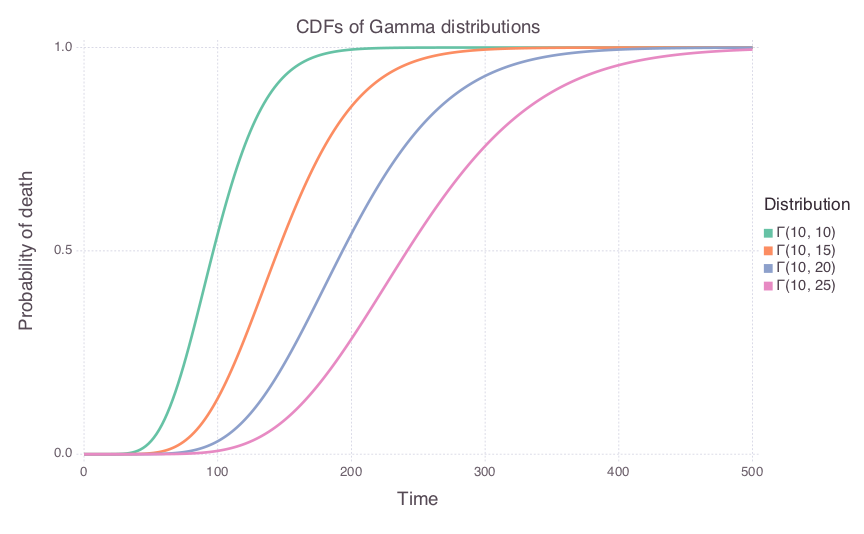

In [10]:
gamDistr = plot(
    [x->cdf(Gamma(10, i), x) for i in [10, 15, 20, 25]][:],
    color=["Γ(10, $i)" for i in [10, 15, 20, 25]][:],
    0, 500,
    Guide.colorkey(title="Distribution"),
    Guide.xlabel("Time"),
    Guide.ylabel("Probability of death"),
    Guide.title("CDFs of Gamma distributions"),
    Scale.color_discrete_manual(gen_brew_colors(4)...),
    style(line_width=2pt, minor_label_font_size=10pt, major_label_font_size=14pt,
            key_label_font_size=11pt, key_title_font_size=13pt,
            colorkey_swatch_shape=:square))

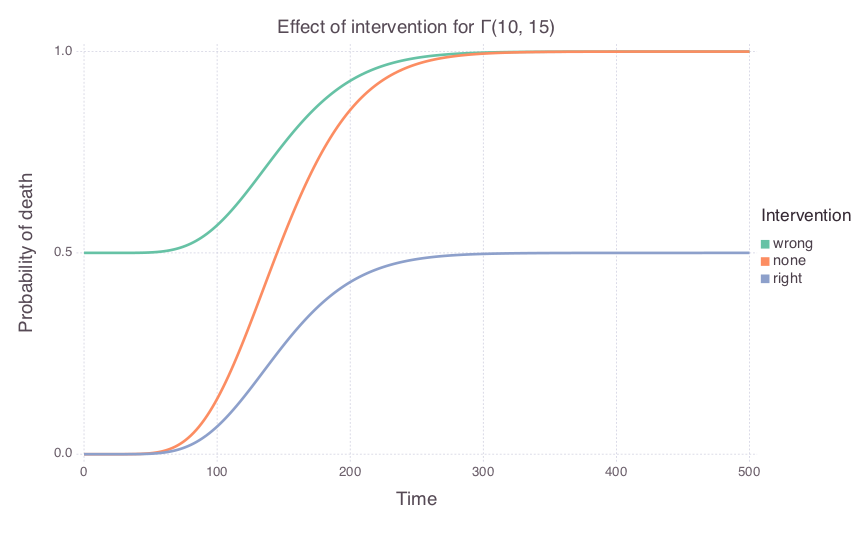

In [11]:
gammaInter = plot(
    [x->(1 + cdf(Gamma(10, 15), x))/2,
     x->cdf(Gamma(10, 15), x),
     x->cdf(Gamma(10, 15), x)/2,
     ],
    color=["wrong", "none", "right"],
    0, 500,
    Guide.colorkey(title="Intervention"),
    Guide.xlabel("Time"),
    Guide.ylabel("Probability of death"),
    Guide.title("Effect of intervention for Γ(10, 15)"),
    Scale.color_discrete_manual(gen_brew_colors(3)...),
    style(line_width=2pt, minor_label_font_size=10pt, major_label_font_size=14pt,
            key_label_font_size=11pt, key_title_font_size=13pt,
            colorkey_swatch_shape=:square))

### Simulations

In [12]:
# starting position: 50 Bayesians, and 50 agents per other group, with varying values for c (varying between 0 and 0.25)
@everywhere const numb_agents = 200
groupID = repeat(1.0:4.0, inner=div(numb_agents, 4))
population_start = vcat(fill(0, div(numb_agents, 4)), rand(Uniform(0, .25), 3*div(numb_agents, 4)))
pop_start = Array{Float32, 2}(hcat(groupID, population_start));

In [13]:
@everywhere function survGam(upds::Array{Float32, 2},
    hyp::Int64, 
    shape::Int64=10, 
    scale::Float64=rand(Uniform(10, 25)),
    thresh::Float64=.9,
    a::Float64=rand(Uniform(1, 10)), 
    b::Float64=rand(Uniform(1, 10)))
    
    t::Int64 = findfirst(upds .> thresh) # where in the matrix with probability updates do we find the first value above thresh?
    c::Int64 = cld(t, numb_toss + 1) # in which column is it?
    p::Int64 = t - (c - 1) * (numb_toss + 1) # in which row is it? (at which time does it occur?)
    
    if c == hyp
        1 - (cdf(Gamma(shape, scale), p) / a) # the probability goes down if the right intervention is made (and the right intervention is made if the truth is assigned a probability above thresh)
    elseif c == 0
        1 - cdf(Gamma(shape, scale), numb_toss + 1) # if no intervention is made, output survival probability at last time step
    else
        (1 + (b - 1) * cdf(Gamma(shape, scale), p)) / b # the probability goes down if the wrong intervention is made (which happens if a false hypothesis is assigned a probabilty above thresh)
    end
end

In [14]:
@everywhere function score(rule_index::Float32, c_value::Float32)

    rand_hyp::Int64 = rand(1:11) # pick bias hypothesis

    @fastmath @inbounds data::Array{Bool, 1} = datFunc((rand_hyp - 1) / (numb_hyp - 1)) # generate synthetic data for this pick
    
    updates = Array{Float32}(numb_toss + 1, numb_hyp) # initialize array for probabilities

    updates[1, :] = prior # set prior

    if rule_index == 1.0f0
        @fastmath @inbounds for t in 1:numb_toss # generate updates
            updates[t + 1, :] = b_upd(updates[t, :], data, t)
        end
    elseif rule_index == 2.0f0
        @fastmath @inbounds for t in 1:numb_toss # generate updates
            updates[t + 1, :] = expl_upd(updates[t, :], data, t, c_value)
        end
    elseif rule_index == 3.0f0
        @fastmath @inbounds for t in 1:numb_toss # generate updates
            updates[t + 1, :] = good_upd(updates[t, :], data, t, c_value)
        end
    else
        @fastmath @inbounds for t in 1:numb_toss # generate updates
            updates[t + 1, :] = pop_upd(updates[t, :], data, t, c_value)
        end
    end

    @fastmath @inbounds return survGam(updates, rand_hyp)
    
end

In [15]:
@everywhere const numb_reruns = 100

# to test every agent on 100 runs (patients), we use the following function
@everywhere @fastmath @inbounds function avScore(rule_index::Float32, c_value::Float32)
    tot = @parallel (+) for i in 1:numb_reruns
        score(rule_index, c_value)
    end
    return tot / numb_reruns # average survival score obtained by this agent
end

In [16]:
function population_upd_rep(pop::Array{Float32, 2})

    agent_scores = SharedArray{Float32, 1}(numb_agents)

    @sync @parallel for i in 1:numb_agents
        @inbounds @fastmath agent_scores[i] = avScore((pop[i, :])...)
    end

    best_index = find(agent_scores .> median(agent_scores))

    best = pop[best_index,:]

    return vcat(best, best), agent_scores

end

population_upd_rep (generic function with 1 method)

In [17]:
const numb_generations = 100

pop_upd_c_a = Array{Float32, 3}(numb_agents, 2, numb_generations + 1)
pop_upd_f = Array{Float32, 2}(numb_agents, numb_generations + 1) # fitness scores (so survival probabilities)

pop_upd_c_a[:, :, 1] = pop_start

@fastmath @inbounds for i in 1:numb_generations
    pop_upd_c_a[:, :, i + 1], pop_upd_f[:, i] = population_upd_rep(pop_upd_c_a[:, :, i])
end

@fastmath @inbounds for i in 1:numb_agents
    pop_upd_f[i, numb_generations + 1] = avScore((pop_upd_c_a[i, 1:2, numb_generations + 1])...)
end

In [18]:
res_a = Array{Int32, 2}(numb_agents, numb_generations + 1)
res_c = Array{Float32, 2}(numb_agents, numb_generations + 1)

for i in 1:numb_generations + 1
     res_a[:, i], res_c[:, i] = pop_upd_c_a[:, 1, i], pop_upd_c_a[:, 2, i]
end

### Plotting

In [19]:
ks = [keys(sort(countmap(res_a[:,i]))) for i in 1:numb_generations + 1]
vls = [values(sort(countmap(res_a[:,i]))) for i in 1:numb_generations + 1]

group = []
freq = []
gen = []

for i in 1:(numb_generations + 1)
    append!(group, collect(ks[i]))
    append!(freq, collect(vls[i]))
    append!(gen, fill(i, length(collect(ks[i]))))
end

bar_df = convert(DataFrame, hcat(group, freq, gen))

bar_df[:x4] = map(bar_df[:x1]) do x
    if x == 1
        return "Bayes"
    elseif x == 2
        return "EXPL"
    elseif x == 3
        return "Good"
    else
        return "Popper"
    end
end

names!(bar_df, [Symbol("$i") for i in ["Group", "Count", "Generation", "Rule"]]);

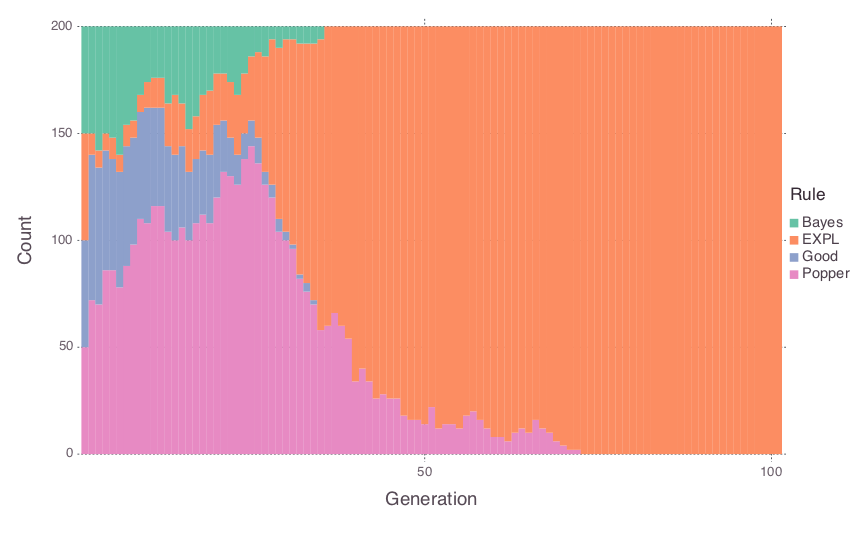

In [20]:
plot(bar_df, x=:Generation, y=:Count, color=:Rule, Geom.bar(position=:stack),
    Coord.cartesian(xmin=1, xmax=numb_generations + 1),
    Guide.colorkey(title="Rule"),
    Scale.color_discrete_manual(gen_brew_colors(4)...),
    style(minor_label_font_size=10pt, major_label_font_size=14pt,
            key_label_font_size=11pt, key_title_font_size=13pt,
            grid_color=colorant"#222831",
            colorkey_swatch_shape=:square))

### Saving just the last state

In [21]:
function population_upd_var(pop::Array{Float32, 2})

    agent_scores = SharedArray{Float32, 1}(200)

    @sync @parallel for i in 1:200
        @inbounds @fastmath agent_scores[i] = avScore((pop[i, :])...)
    end

    best_index = find(agent_scores .> median(agent_scores))

    best = pop[best_index,:]

    return vcat(best, best)

end

population_upd_var (generic function with 1 method)

In [22]:
function last_pop()
    x0::Array{Float32, 2} = Array{Float32, 2}(hcat(repeat(1.0:4.0, inner=50), vcat(fill(0, 50), rand(Uniform(0, .25), 150))))
    i::Int = 1
    while i < 101
        x_upd = population_upd_var(x0)
        x0 .= x_upd
        length(unique(x0[:,1])) == 1 && break
        i += 1
        x_upd = nothing
        gc()
    end
    return x0
end

last_pop (generic function with 1 method)

In [23]:
i = 1
while i < 101
    res = last_pop()
    writedlm("data/rep/GAMlastType$i.txt", res[:,1])
    writedlm("data/rep/GAMlastCval$i.txt", res[:,2])
    i += 1
    res = nothing
    gc()
end

In [24]:
last_results = Array{Int64, 2}(200, 100)

for i in 1:100
    last_results[:, i] = readdlm("data/rep/GAMlastType$i.txt")
end

In [25]:
countmap([last_results...])

Dict{Int64,Int64} with 3 entries:
  4 => 14158
  2 => 5440
  3 => 402

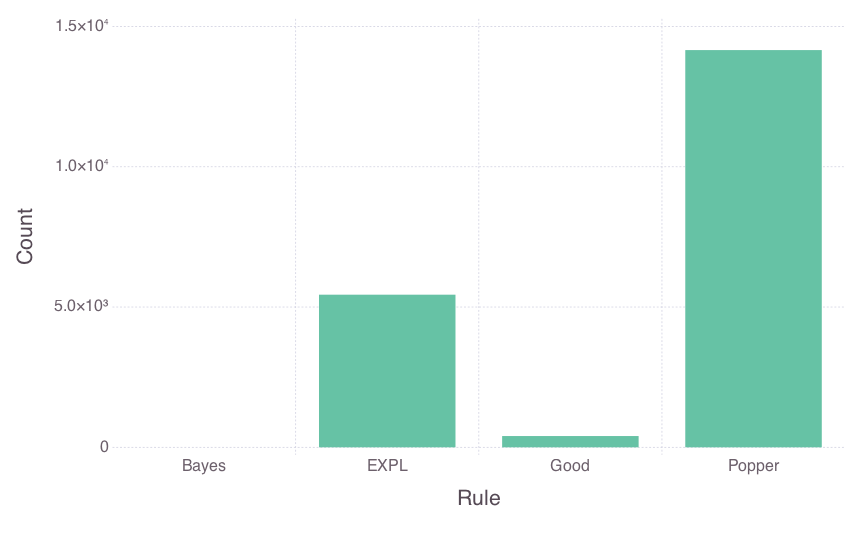

In [26]:
plot(x = ["Bayes", "EXPL", "Good", "Popper"], y = [0, 5440, 402, 14158], Geom.bar,
    Guide.xlabel("Rule"),
    Guide.ylabel("Count"),
    Scale.x_discrete,
    style(default_color=colorant"#66c2a5", minor_label_font_size=12pt, major_label_font_size=16pt,
            key_label_font_size=11pt, key_title_font_size=14pt, bar_spacing=35pt,
            key_position = :none))

In [27]:
last_resultsC = Array{Float64, 2}(200, 100)

for i in 1:100
    last_resultsC[:, i] = readdlm("data/rep/GAMlastCval$i.txt")
end

In [28]:
df = DataFrame(Rule = [last_results...], C_value = [last_resultsC...])
sort!(df, cols=:Rule)
df[:Rule] = map(df[:Rule]) do x
    if x == 2
        return "EXPL"
    elseif x == 3
        return "Good"
    else
        return "Popper"
    end
end;

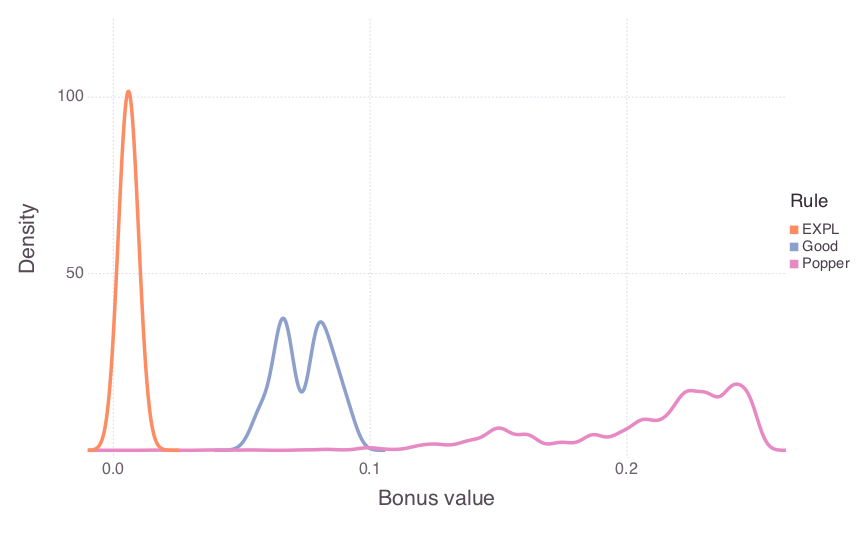

In [29]:
plot(df, x=:C_value, color=:Rule, Geom.density(bandwidth=.0035),
     Coord.cartesian(xmin=-.007, xmax=.259, ymax=120),
     Scale.color_discrete_manual(gen_brew_colors(4)[2:4]...),
     Guide.xlabel("Bonus value"),
     Guide.ylabel("Density"),
     style(line_width=2.65pt, minor_label_font_size=12pt, major_label_font_size=16pt,
            key_label_font_size=11pt, key_title_font_size=14pt,
            colorkey_swatch_shape=:square))